In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import kmeans_segmentation as kseg
%matplotlib inline

from skimage import feature, measure
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import label
from skimage.io import imread, imshow

## 1. Image preparation

In this preliminary part, the image will be processed so that it is ready for texture analysis:
- removing non microstructure information
- sampling a 200x200 pixel^2 window
- equalize contrast with a blurring filter (gaussian, median...)
- After applying the filter, rescale image pixel values between 0 and 255
- subsampling image to prepare for GLCM algorithm processing

In [2]:
image_name = "2015_09_10_700(10)_q015.tif"
mic = kseg.prepare_image(image_name)
mic.shape

(895, 1280)

In [3]:
from skimage.morphology import rectangle
from skimage.util.shape import view_as_windows
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity

In [8]:
# extract the top left part of original image and use a blur filter (gaussian kernel)
mic_s1 = mic[:200, :200].copy()
mic_s1 = gaussian(mic_s1, sigma=1.0)
# rescale intensities
mic_s1 = rescale_intensity(mic_s1, out_range=np.uint8)

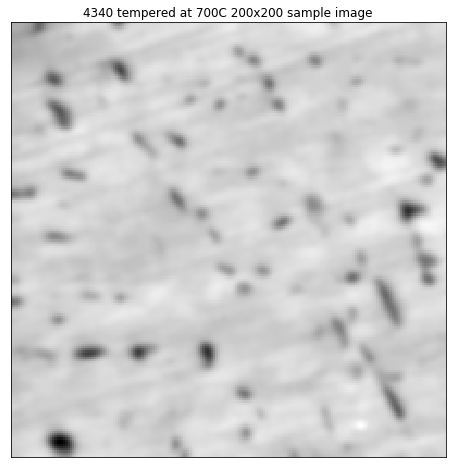

In [9]:
fig, ax = kseg.plot_single_image(gaussian(mic_s1, sigma=1.0))
ax.set_title('4340 tempered at 700C 200x200 sample image')

## 2. Compute GLCM feature images

The next steps is to analyze micrographs through the grey level co-occurrence matrix and its properties. To do that a simple algorithm has been devised:
- The image is examined pixel by pixel
- around each (interior) pixel, a 5x5 window is constructed and the (1 pixel, west) GLC matrix is constructed.
- using the GLC matrix, some properties of the pixel neighborhood is computed: contrast, dissimilarity, homogeneity, energy and correlation.
- each property is stored in a GLC property image for later use (segmentation)

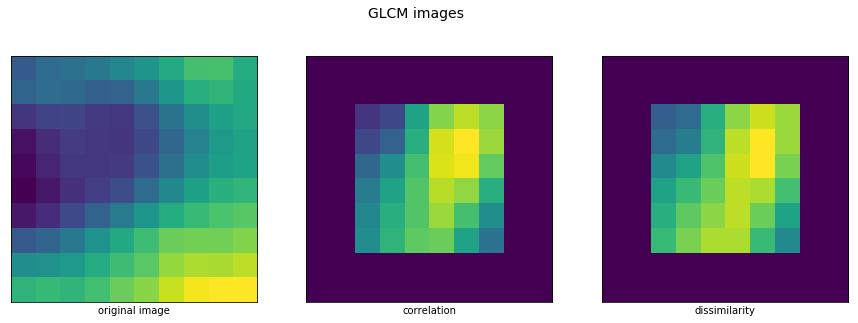

In [10]:
def GLCM_image(original, window_shape=(5,5), props=('contrast', 'dissimilarity')):
    """ Compute GLCM pixel values 
        
        original : original 8 bit image
        window_shape : shape of sliding window
        props : list-like object of GLC matrix properties to compute
        
        Returns
        -------
        GLCM property image stack 
    """
    sub_views = view_as_windows(original, window_shape)
    glc_shp = (original.shape[0], original.shape[1], len(props))
    glc_image = np.zeros(glc_shp)
    border = (int(np.floor(window_shape[0] / 2.0)), int(np.floor(window_shape[1] / 2.0)))
    for row_idx in range(border[0], glc_image.shape[0] - border[0]):
        for col_idx in range(border[1], glc_image.shape[1] - border[1]):
            patch = sub_views[row_idx - border[0], col_idx - border[1], :, :]
            glcm = greycomatrix(patch, [1], [0], 256, symmetric=True, normed=True)
            for i, prop in enumerate(props):
                glc_image[row_idx, col_idx, i] = greycoprops(glcm, prop)[0, 0]
    return glc_image

# A little test
mic_s_test = mic_s1[10:20, :10].copy()
glc_test = GLCM_image(mic_s_test)

cmap = 'viridis'
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(mic_s_test, cmap=cmap, interpolation='nearest')
ax.set_xlabel('original image')
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 3, 2)
ax.imshow(glc_test[:, :, 0], cmap=cmap, interpolation='nearest')
ax.set_xlabel('correlation')
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 3, 3)
ax.imshow(glc_test[:, :, 1], cmap=cmap, interpolation='nearest')
ax.set_xlabel('dissimilarity')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')
fig.suptitle('GLCM images', fontsize=14)

In [11]:
# A little test
mic_s_test = mic_s1[:50, :50]
properties = ('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation')
glc_test = GLCM_image(mic_s_test, props=properties)

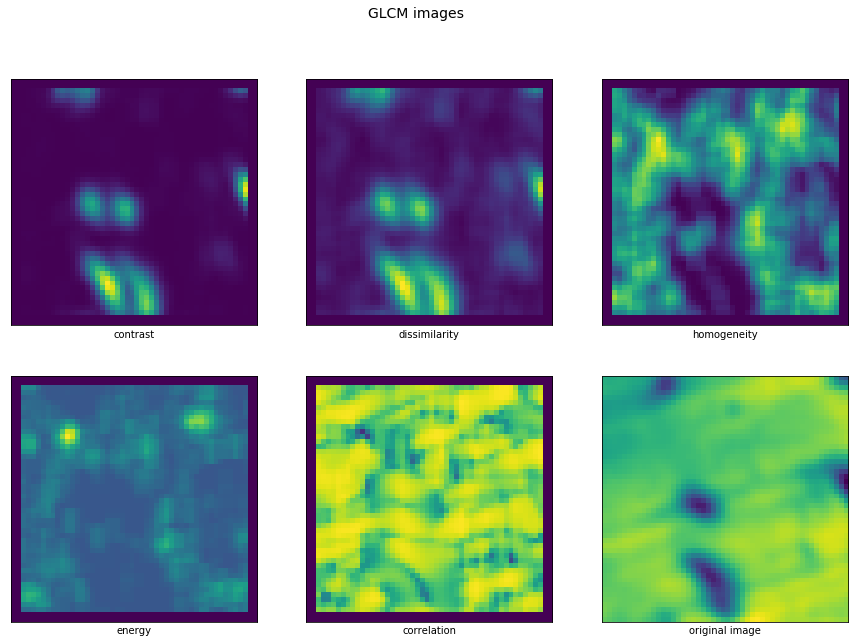

In [12]:
cmap = 'viridis'
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
i = 0
for row in ax:
    for col in row:
        try:
            col.imshow(glc_test[:, :, i], cmap=cmap, interpolation='nearest')
            col.set_xlabel(properties[i])
            col.set_xticks([])
            col.set_yticks([])
            col.axis('image')
            i = i + 1
        except IndexError:
            col.imshow(mic_s_test, cmap=cmap, interpolation='nearest')
            col.set_xlabel('original image')
            col.set_xticks([])
            col.set_yticks([])

fig.suptitle('GLCM images', fontsize=14)

In [13]:
mic_s_test = mic_s1.copy()
properties = ('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation')
glc_test = GLCM_image(mic_s_test, props=properties)

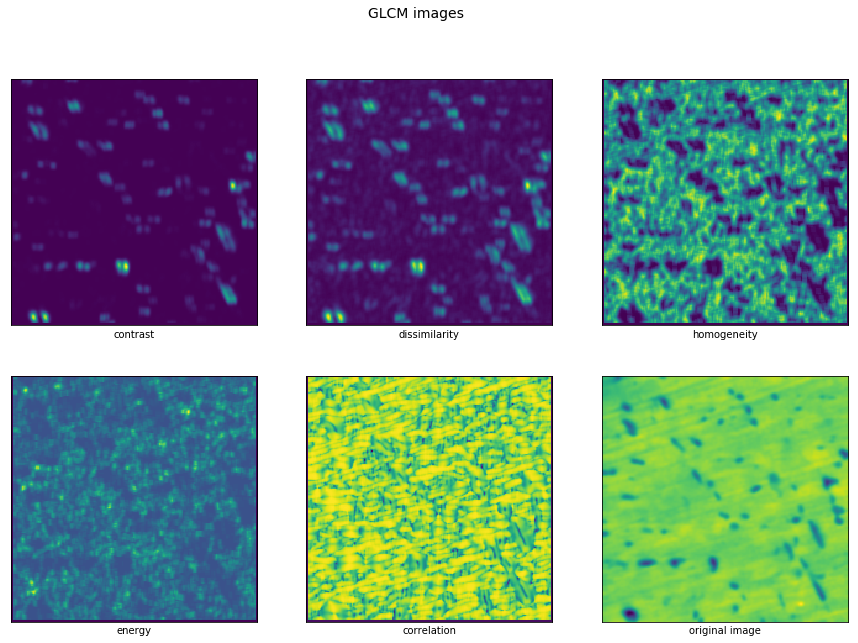

In [14]:
cmap = 'viridis'
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
i = 0
for row in ax:
    for col in row:
        try:
            col.imshow(glc_test[:, :, i], cmap=cmap, interpolation='nearest')
            col.set_xlabel(properties[i])
            col.set_xticks([])
            col.set_yticks([])
            col.axis('image')
            i = i + 1
        except IndexError:
            col.imshow(mic_s_test, cmap=cmap, interpolation='nearest')
            col.set_xlabel('original image')
            col.set_xticks([])
            col.set_yticks([])

fig.suptitle('GLCM images', fontsize=14)

Results calculated: 24 clusters, 10 centroid initializations


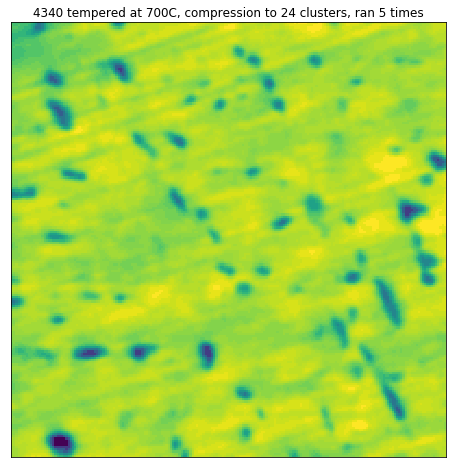

In [16]:
comp_mic_nc24 = kseg.k_means_segmentation(mic_s_test, n_clusters=24, n_init=10)
fig, ax = kseg.plot_single_image(comp_mic_nc24, cmap='viridis')
ax.set_title("4340 tempered at 700C, compression to 24 clusters, ran 5 times")

In [18]:
properties = ('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation')
glc_test = GLCM_image(comp_mic_nc24, props=properties)

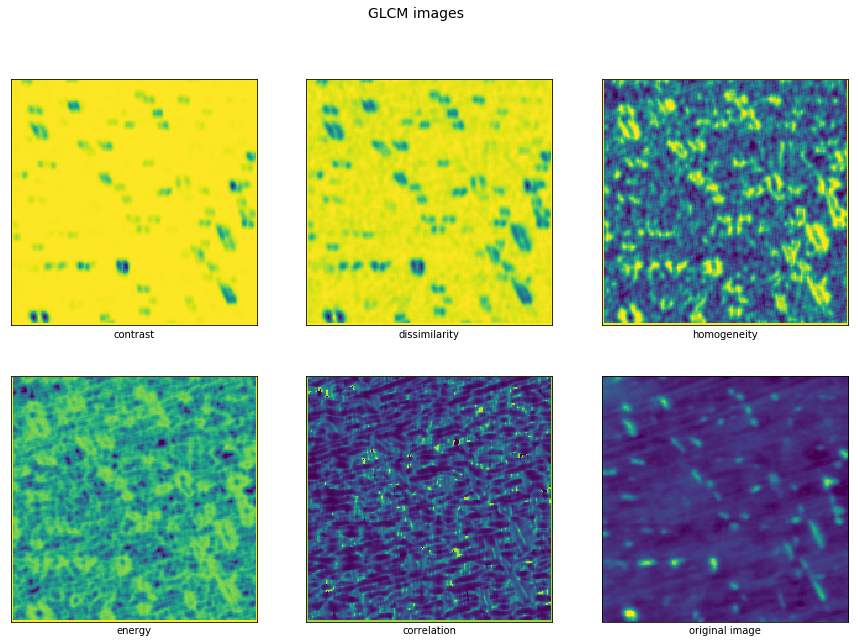

In [33]:
cmap = 'viridis_r'
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
i = 0
for row in ax:
    for col in row:
        try:
            col.imshow(glc_test[:, :, i], cmap=cmap, interpolation='nearest')
            col.set_xlabel(properties[i])
            col.set_xticks([])
            col.set_yticks([])
            col.axis('image')
            i = i + 1
        except IndexError:
            col.imshow(comp_mic_nc24, cmap=cmap, interpolation='nearest')
            col.set_xlabel('original image')
            col.set_xticks([])
            col.set_yticks([])

fig.suptitle('GLCM images', fontsize=14)

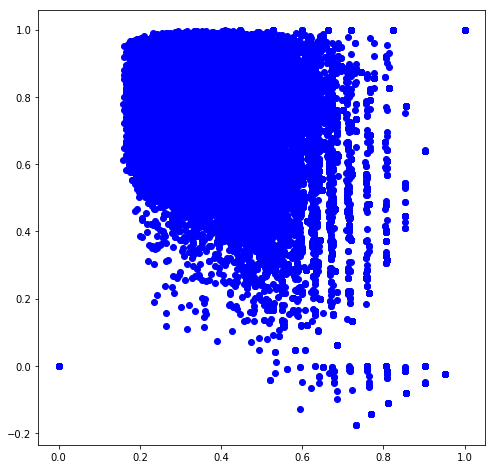

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
# contrast / homogeneity
ax.plot(glc_test[:, :, 3], glc_test[:, :, 4], 'ob')
plt.show()